# Predicting Mental Health using the BRFSS – CRISP-DM Analysis 
## Portfolio Assignment Anja Tolpekina

----

### 1. Import Modules and Data

In [1]:
# If you don't have imbalanced-learn installed already, run the following line
pip install imbalanced-learn

In [2]:
# Import the modules and packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# Import the dataset as dataframe
df = pd.read_csv('2015.csv')

----
### 2. Data Preparation

In [4]:
# Select the columns that will be used to build a model
columns = ['GENHLTH','PHYSHLTH','MENTHLTH','POORHLTH','HLTHPLN1','PERSDOC2','MEDCOST','CHECKUP1','BPHIGH4','TOLDHI2',
           'CVDINFR4','CVDCRHD4','CVDSTRK3','CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','DIABETE3',
           'SEX','MARITAL','EDUCA','RENTHOM1','VETERAN3','EMPLOY1','CHILDREN','INCOME2','INTERNET','QLACTLM2', 'USEEQUIP',
           'BLIND','DECIDE','DIFFWALK','DIFFDRES','DIFFALON','HIVTST6','SXORIENT','TRNSGNDR','ADPLEASR','ADDOWN','ADSLEEP',
           'ADENERGY','ADEAT1','ADFAIL','ADTHINK','ADMOVE','MISTMNT','ADANXEV','_ASTHMS1','_DRDXAR1','_RACE','_AGE80','HTM4',
           'WTKG3','_BMI5','_SMOKER3','_RFBING5','_DRNKWEK','_FRUTSUM','_VEGESUM','STRFREQ_','_PACAT1','_PAINDX1']

# Create a subset of the data that only contains the selected columns and store it as a new dataframe
df_selected = pd.DataFrame(df[columns])

In [5]:
# The values 7 & 9, 77 & 99, and 99900 have been used in certain columns to represent 'Don't know/Not sure' and 'Refused'.
# These values will be treated as missing values as they are not very informative.

# Select the columns where 7 and 9 represent the values 'Don't know/Not sure' and 'Refused'
columns79 = ['GENHLTH','HLTHPLN1','MEDCOST','PERSDOC2','CHECKUP1','BPHIGH4','TOLDHI2','CVDINFR4','CVDCRHD4','CVDSTRK3',
             'CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','DIABETE3','MARITAL','EDUCA','RENTHOM1',
             'INTERNET','QLACTLM2','USEEQUIP','BLIND','DECIDE','DIFFWALK','DIFFDRES','DIFFALON','HIVTST6','TRNSGNDR',
             'MISTMNT','ADANXEV','_ASTHMS1','_DRDXAR1','_RACE','_SMOKER3','_RFBING5','_PACAT1','_PAINDX1']

# Replace the values 7 and 9 with NaN-values
df_selected[columns79] = df_selected[columns79].replace(to_replace = (7,9) , value = np.nan)

# In column EMPLOY1 9 represents the value 'Refused' but 7 represents 'Retired', we dont want to lose these values so only the
# instances with values 9 will be replaced with NaN-values.
df_selected['EMPLOY1'] = df_selected['EMPLOY1'].replace(to_replace = 9 , value = np.nan)

# Select the columns where 77 and 99 represent the values 'Don't know/Not sure' and 'Refused'
columns7799 = ['PHYSHLTH','MENTHLTH','POORHLTH','CHILDREN','INCOME2','ADPLEASR','ADDOWN','ADSLEEP','ADENERGY','ADEAT1',
               'ADFAIL','ADTHINK','ADDOWN']

# Replace the values 77 and 99 with NaN-values
df_selected[columns79] = df_selected[columns79].replace(to_replace = (77,99) , value = np.nan)

# Select columns where 99900 represents the value 'Don’t know/Refused/Missing'
columns99900 = ['_DRNKWEK','STRFREQ_']

# Replace the value 99900 with NaN-values
df_selected[columns99900] = df_selected[columns99900].replace(to_replace = 99900 , value = np.nan)

# Drop all rows containing NaN-values
df_dropna = df_selected.dropna()

In [6]:
# Disable the SettingWithCopyWarning, it is used to flag potentially confusing "chained" assignment, however it is not
# needed in this case
pd.options.mode.chained_assignment = None  # default='warn'

# The value 88 has been used in these columns to represent 'None'
columns88 = ['PHYSHLTH','MENTHLTH','POORHLTH','CHILDREN','ADPLEASR','ADDOWN','ADSLEEP','ADENERGY','ADEAT1','ADFAIL','ADTHINK',
            'ADMOVE']

# Replace 88 with 0 in the selected columns
df_dropna[columns88] = df_dropna[columns88].replace(88, 0)

# Select the columns where the responses 'Yes'/'No' have been encoded as 1/2
columns12 = ['HLTHPLN1','MEDCOST','TOLDHI2','CVDINFR4','CVDCRHD4','CVDSTRK3','CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3',
           'ADDEPEV2','CHCKIDNY','SEX','VETERAN3','INTERNET','QLACTLM2','USEEQUIP','BLIND','DECIDE','DIFFWALK','DIFFDRES',
           'DIFFALON','HIVTST6','MISTMNT','ADANXEV','_DRDXAR1','_SMOKER3','_PAINDX1']

# Replace 2 with 0 in the selected columns
df_dropna[columns12] = df_dropna[columns12].replace(2,0)

# Drop duplicate rows
df_dropna = df_dropna.drop_duplicates()

# Rewrite the dataset to integer type
df_recoded = df_dropna.astype(int)

In [7]:
# Implement one-hot encoding for the ordinal/categorical variables by making dummy variables
df_dummy = pd.get_dummies(df_recoded, columns = ['GENHLTH','PERSDOC2','CHECKUP1','BPHIGH4','DIABETE3','MARITAL','EDUCA',
                                                 'RENTHOM1','EMPLOY1','INCOME2','SXORIENT','TRNSGNDR','_ASTHMS1','_RACE',
                                                 '_SMOKER3','_RFBING5','_PACAT1'])

----
### 3. Modelling

In [8]:
# Split the data into independent variable (X) and dependent variables (y)
X = df_dummy.drop('MISTMNT', axis = 1).copy()
y = df_dummy['MISTMNT'].copy()

# Split the data into a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split the test set in two to get a validation set (both 10% of the total data set)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check if we have class imbalance in the independent variable in the training set
np.bincount(y_train)

array([1015,  397], dtype=int64)

In [9]:
# There is class imbalance, so we will resample the training data
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Check if it worked correctly, both classes should be represented equally
np.bincount(y_res)

array([1015, 1015], dtype=int64)

In [10]:
# Train the decision tree on the resampled training data
dt = DecisionTreeClassifier(random_state = 42)
dt = dt.fit(X_res, y_res)

In [11]:
# Use cost_complexity_pruning_path to get the effective alphas of subtrees   
path = dt.cost_complexity_pruning_path(X_res, y_res)

# Get the different values for alpha
ccp_alphas = path.ccp_alphas

# Exclude -1 as value for alpha, as this would prune all the leaves of the tree
ccp_alphas = ccp_alphas[:-1]

# Create an empty array to store the different decision trees
dts = []

# For every alpha create one decision tree and store it in the array
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    dts.append(dt)

<AxesSubplot:xlabel='alpha'>

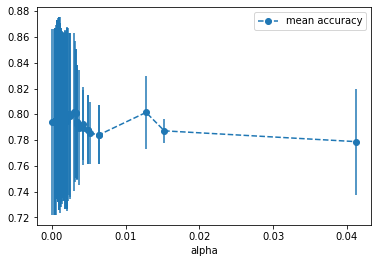

In [12]:
# Next use cross validation to find the best value for alpha

# Create an array to store the results of each fold during cross validiation
alpha_loop_values = []

# Run 10-fold cross validation for each different value for alpha in ccp_alphas.
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    # Calcuate average accuracy of tree with this ccp_alpha value
    scores = cross_val_score(dt, X_res, y_res, cv=5)
    # Store the alpha, mean accuracy and standard deviation 
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Store the results of the 10-fold cross validation in a dataframe
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean accuracy', 'std'])

# Create a plot to show the different alpha values and their mean accuracy and standard deviation
alpha_results.plot(x='alpha', y='mean accuracy', yerr='std', marker='o', linestyle='--')

The alpha with the highest mean accuracy is very close to 0. That does not help us prune our tree very much, in addition it 
has very high standard deviation and therefore gives variable results. However, there is a second peak between 0.01 and 0.02
alpha which we will use for our tree.

In [13]:
# Filter out all values for alpha below 0.01
alpha_filtered = alpha_results[alpha_results['alpha'] > 0.01]

# Select the row index where mean accuracy is the highest
max_index = alpha_filtered["mean accuracy"].idxmax()

#Select the alpha value which corresponds to the highest mean accuracy
ideal_ccp_alpha = alpha_results.iloc[max_index]['alpha']

In [14]:
# Create a pruned decision tree by using the ideal alpha that we calculated
dt_pruned = DecisionTreeClassifier(random_state=42, 
                                       ccp_alpha=ideal_ccp_alpha)
dt_pruned = dt_pruned.fit(X_res, y_res) 

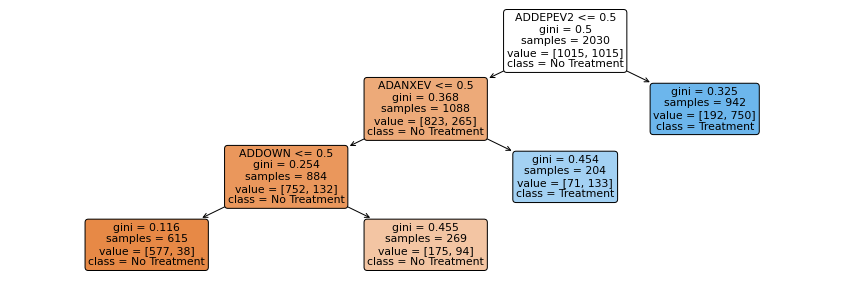

In [15]:
# Plot the pruned decision tree
plt.figure(figsize=(15, 5))
plot_tree(dt_pruned, filled = True, rounded = True, class_names = ["No Treatment","Treatment"], 
                 feature_names=X.columns)
plt.show()

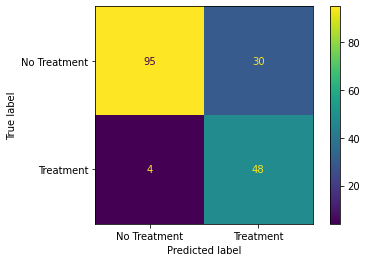

In [16]:
# Plot the confusion matrix to see how the new tree performed
confusion_matrix = ConfusionMatrixDisplay.from_estimator(dt_pruned, X_val, y_val, display_labels = 
                                      ["No Treatment","Treatment"])
plt.show()

In [17]:
# To see how well the model performed print out the accuracy
print(f'The model accuracy is {dt_pruned.score(X_test, y_test):.3f}')

# Because we had unbalanced classed, it is useful to look at the balanced accuracy as well
print(f'The balanced model accuracy is {balanced_accuracy_score(y_test, dt_pruned.predict(X_test)):.3f}')

The model accuracy is 0.808
The balanced model accuracy is 0.858


Random forest is another useful classification technique. This method can often have a better performance than decision trees, however random forest is generally less interpretable and can be biased when dealing with a large number of categorical variables. To see whether it yields better results, a random forest model will be run.

In [18]:
# Fit the random forst classifier on the data, use n_estimators = 300
model = RandomForestClassifier(n_estimators=300)
model.fit(X_res, y_res)

RandomForestClassifier(n_estimators=300)

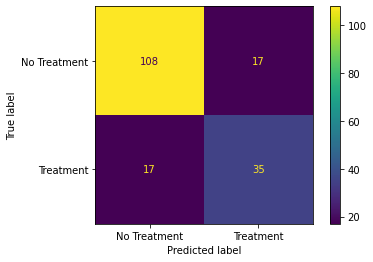

In [19]:
# Plot the confusion matrix to see how the random forest performed
confusion_matrix = ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, display_labels = 
                                      ["No Treatment","Treatment"])
plt.show()

In [20]:
# To see how well the model performed print out the accuracy
print(f'The model accuracy is {model.score(X_val, y_val):.3f}')

# Because we had unbalanced classed, it is useful to look at the balanced accuracy as well
print(f'The balanced model accuracy is {balanced_accuracy_score(y_test, model.predict(X_test)):.3f}')

The model accuracy is 0.808
The balanced model accuracy is 0.819


The random forest classifier had a better performance in the validation set. Now that all parameters are tuned, we will use the testing set to get the accuracy of both models to assess which one has the best performance.

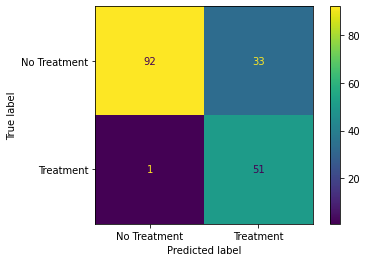

The model accuracy is 0.808
The balanced model accuracy is 0.858


In [21]:
# Plot the confusion matrix to see how the tree performed on the testing set
confusion_matrix = ConfusionMatrixDisplay.from_estimator(dt_pruned, X_test, y_test, display_labels = 
                                      ["No Treatment","Treatment"])
plt.show()

# To see how well the model performed print out the accuracy
print(f'The model accuracy is {dt_pruned.score(X_test, y_test):.3f}')

# Because we had unbalanced classed, it is useful to look at the balanced accuracy as well
print(f'The balanced model accuracy is {balanced_accuracy_score(y_test, dt_pruned.predict(X_test)):.3f}')

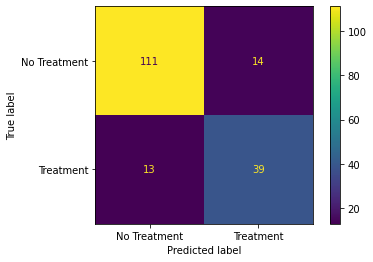

The model accuracy is 0.847
The balanced model accuracy is 0.819


In [22]:
# Plot the confusion matrix to see how the random forst performed on the testing set
confusion_matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels = 
                                      ["No Treatment","Treatment"])
plt.show()

# To see how well the model performed print out the accuracy
print(f'The model accuracy is {model.score(X_test, y_test):.3f}')

# Because we had unbalanced classed, it is useful to look at the balanced accuracy as well
print(f'The balanced model accuracy is {balanced_accuracy_score(y_test, model.predict(X_test)):.3f}')